In [75]:
# import sys
# sys.path.append('..')

import tests.methods.torch_nvd as nvd
import tests.methods.utils as utils

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

import pandas as pd
import networkx as nx

import scipy.stats as st
from scipy.spatial.transform import Rotation as R

from math import comb
import seaborn as sns

# Common test variables
Run python script with variables common to all synthetic experiments, also sets random seed.

In [96]:
%run -i "test_variables.py"

# Defining variables in the notebook for code highlighting purposes
metrics = metrics
local_tests = local_tests
local_num_nodes_range = local_num_nodes_range
random_run_metrics = random_run_metrics
mds_runs = mds_runs
SBM_runs = SBM_runs
node_size = node_size
edge_color = edge_color
local_edge_width = local_edge_width
local_edge_alpha = local_edge_alpha
global_edge_width = global_edge_width
global_edge_alpha = global_edge_alpha
labelpad=labelpad
fontsize=fontsize

# Addition of nodes with unique opinions

In [3]:
experiment_folder = 'correlation/'

### Local Setup

In [106]:
comms = 3  # Number of communities in the local community network
dotp_range = np.arange(0, 1.1, 0.1)
num_nodes = 12
x_range = [0, 0.33, 0.66, 1]
angles_between_opinions = [90,60,30,0]

In [107]:
blue, red, green, grey = utils.cmap('colors')
blue_red_range = list(sns.blend_palette([blue, red], n_colors=len(x_range*2)-1, as_cmap=False).as_hex())
blue_range = blue_red_range[:len(x_range)]
red_range = blue_red_range[len(x_range)-1:][::-1]

Figure saved


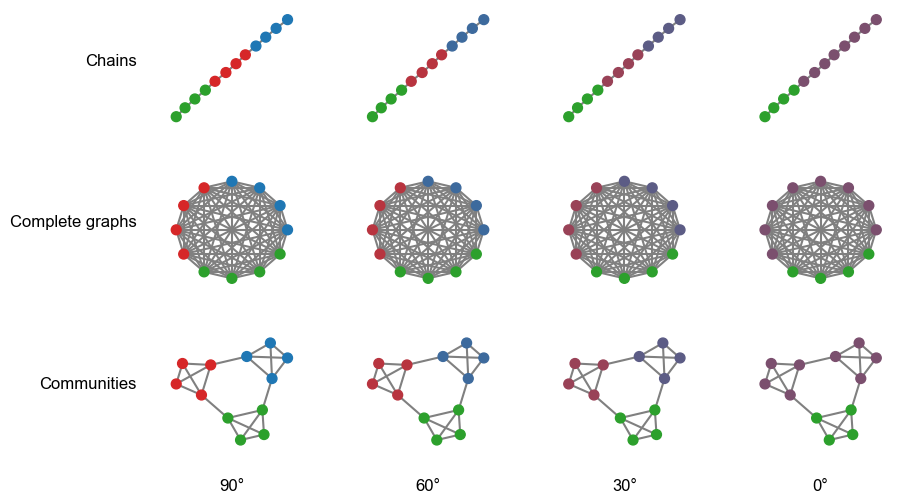

In [110]:
fig, ax = plt.subplots(3, len(x_range), figsize=(2*len(x_range), 5))
fig.tight_layout()

for test_index, (name, graph_gen) in enumerate(local_tests):
    ax[test_index, 0].set_ylabel(name, rotation=0, labelpad=20, fontsize=12, ha='right')
 
    for x_index, opinion_type in enumerate(x_range):

        nodes_per_comm = num_nodes // comms

        if graph_gen == utils.make_community_graph:
            G = graph_gen(comms, nodes_per_comm)
        else:
            G = graph_gen(num_nodes)
        
        pos = nx.kamada_kawai_layout(G) # seed=1, k=10, iterations=1000

        # hide subplot axes lines
        for direction in ['top','right','left','bottom']:
            ax[test_index, x_index].spines[direction].set_visible(False)

        node_colors = [blue_range[x_index]] * nodes_per_comm + [red_range[x_index]] * nodes_per_comm + [green] * nodes_per_comm
        
        nx.draw_networkx_nodes(G, ax=ax[test_index, x_index], pos=pos, node_size=node_size, node_color=node_colors)
        nx.draw_networkx_edges(G, ax=ax[test_index, x_index], edge_color='gray', pos=pos, width=local_edge_width)
        
        # set opinion_type as x-axis label
        ax[2, x_index].set_xlabel(str(angles_between_opinions[x_index])+u'\N{DEGREE SIGN}', fontsize=fontsize, labelpad=labelpad)

utils.save_figure("local_setup", experiment_folder, overwrite=True)

### Local Results

In [51]:
def rotate(vector, degrees, axis=np.array([0, 0, 1]), inplace=False):
    radians = np.radians(degrees)
    rotation_vector = radians * axis
    rotation = R.from_rotvec(rotation_vector)
    if inplace:
        return rotation.apply(vector)
    else:
        vector_copy = vector.copy()
        return rotation.apply(vector_copy)

Figure saved


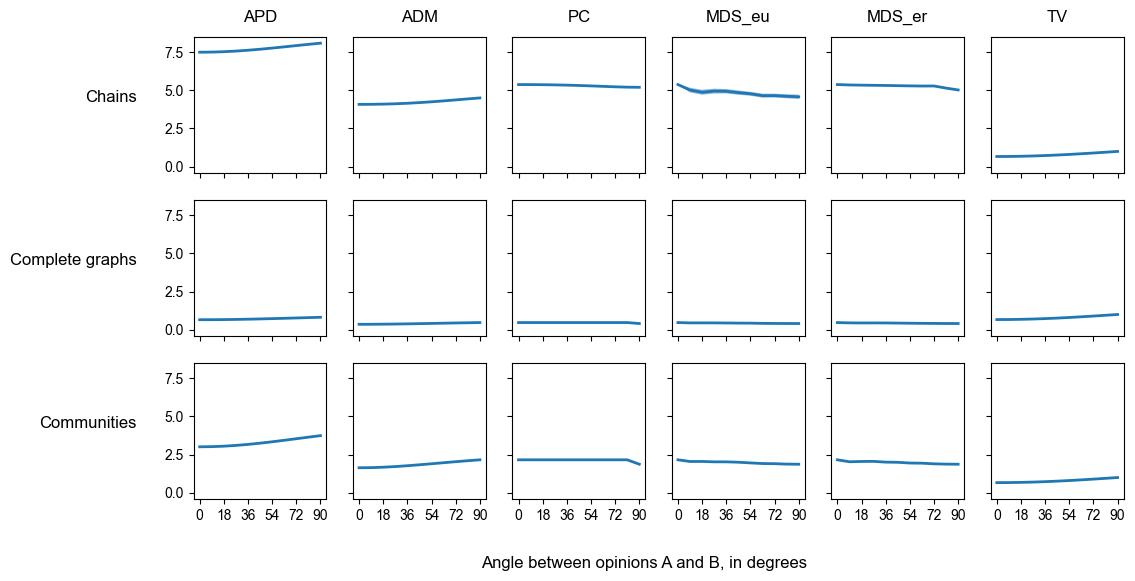

In [32]:
comms = 3  # Number of communities in the local community network
num_nodes = 12
nodes_per_comm = num_nodes//comms

x_range = list(np.round(np.arange(0, 1.1, 0.1), 1))
angles_to_rotate = list(np.round([45*i for i in x_range],1))
angles_between_opinions = [2*a for a in angles_to_rotate[::-1]]

o_blue = np.array([1,0,0])
o_red = np.array([0,1,0])
o_green = np.array([0,0,1])

 
fig, ax = plt.subplots(len(local_tests), len(metrics), figsize=(len(metrics)*2, len(local_tests)*2), sharey=True, sharex=True)

# Set labels and ticks to every 20 degrees
ax[0, 0].set_xticks(angles_between_opinions[::2])
ax[0, 0].set_xticklabels([str(int(a)) for a in angles_between_opinions[::2]]) 

for test_index, (graph_name, graph_type) in enumerate(local_tests):

    for metric_index, (metric_name, polarization_metric) in enumerate(metrics):

        # Initialize arrays to store the means and confidence intervals of repeated runs
        means = np.zeros(len(angles_to_rotate))
        lower_confs = np.zeros(len(angles_to_rotate))
        higher_confs = np.zeros(len(angles_to_rotate))
        angles = np.zeros(len(angles_to_rotate))

        for x_index, rotation_angle in enumerate(angles_to_rotate):

            run_pols = np.zeros(mds_runs)

            for run in range(mds_runs):
            
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=comms, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                # Rotate opinions towards each other
                rot_o_blue = rotate(o_blue, rotation_angle)
                rot_o_red = rotate(o_red, -rotation_angle)

                # print the angle for debugging
                angle = np.arccos(np.clip(np.dot(rot_o_blue, rot_o_red), -1.0, 1.0))

                o = pd.DataFrame(np.vstack((np.array([tuple(rot_o_blue)]*nodes_per_comm),
                                            np.array([tuple(rot_o_red)]*nodes_per_comm),
                                            np.array([tuple(o_green)]*nodes_per_comm))))

                # print(f"{len(G)} nodes, opinions shape: {o.shape}")

                tensor = nvd.make_tensor(G, o)
                polarization = polarization_metric(tensor)
                run_pols[run] = polarization

                # Only keep the first run
                if polarization_metric not in random_run_metrics:
                    run_pols = np.array([run_pols[0]])
                    break
            
            if polarization_metric in random_run_metrics:
                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, run_pols.size)

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, run_pols.size-1, loc=np.mean(run_pols), scale=st.sem(run_pols)) # means[x_index]

                lower_confs[x_index] = lower_conf
                higher_confs[x_index] = higher_conf

            means[x_index] = np.mean(run_pols)

            # Store the angle in degrees for debugging
            angles[x_index] = np.degrees(angle)

        if polarization_metric in random_run_metrics:
            ax[test_index, metric_index].fill_between(angles_between_opinions, higher_confs, lower_confs, alpha=.5, linewidth=0)

        # Draw line at 0 for layout purposes
        ax[test_index, metric_index].hlines(0, angles_between_opinions[0]-1, xmax=angles_between_opinions[-1]+1, colors='dimgrey', alpha=0, linestyles='dashed', label='Expected')

        ax[test_index, metric_index].plot(angles_between_opinions, means, lw=2)

        # Add title to the first row
        if test_index == 0:
            ax[test_index, metric_index].set_title(metric_name, fontsize=12, y=1.05, ha='center')

        # Add title to the first column
        if metric_index == 0:
            ax[test_index, metric_index].set_ylabel(graph_name, rotation=0, labelpad=20, fontsize=12, ha='right')

        # print(angles)

# fig.supylabel('Polarization', x=0.08)
fig.supxlabel('Angle between opinions A and B, in degrees', fontsize=12, y=-0.01)

utils.save_figure("local_res", experiment_folder, overwrite=True)

### Global Setup

In [65]:
# Experiment variables

p_in = 0.1
p_out = 0.01
n_comms = 3
intercon = n_comms-1
nodes_per_comm = 100

x_range = [0, 0.33, 0.66, 1]
n_graphs = len(x_range)

def generate_n_graphs(n_graphs, n_comms, nodes_per_comm, p_in, p_out, community_labels = False, positions = False):
    return [utils.stochastic_block_model(n_comms, nodes_per_comm, p_in, p_out, community_labels, positions) for _ in range(n_graphs)]

blue, red, green, grey = utils.cmap('colors')
blue_red_range = list(sns.blend_palette([blue, red], n_colors=len(x_range*2)-1, as_cmap=False).as_hex())
blue_range = blue_red_range[:len(x_range)]
red_range = blue_red_range[len(x_range)-1:][::-1]

Figure saved


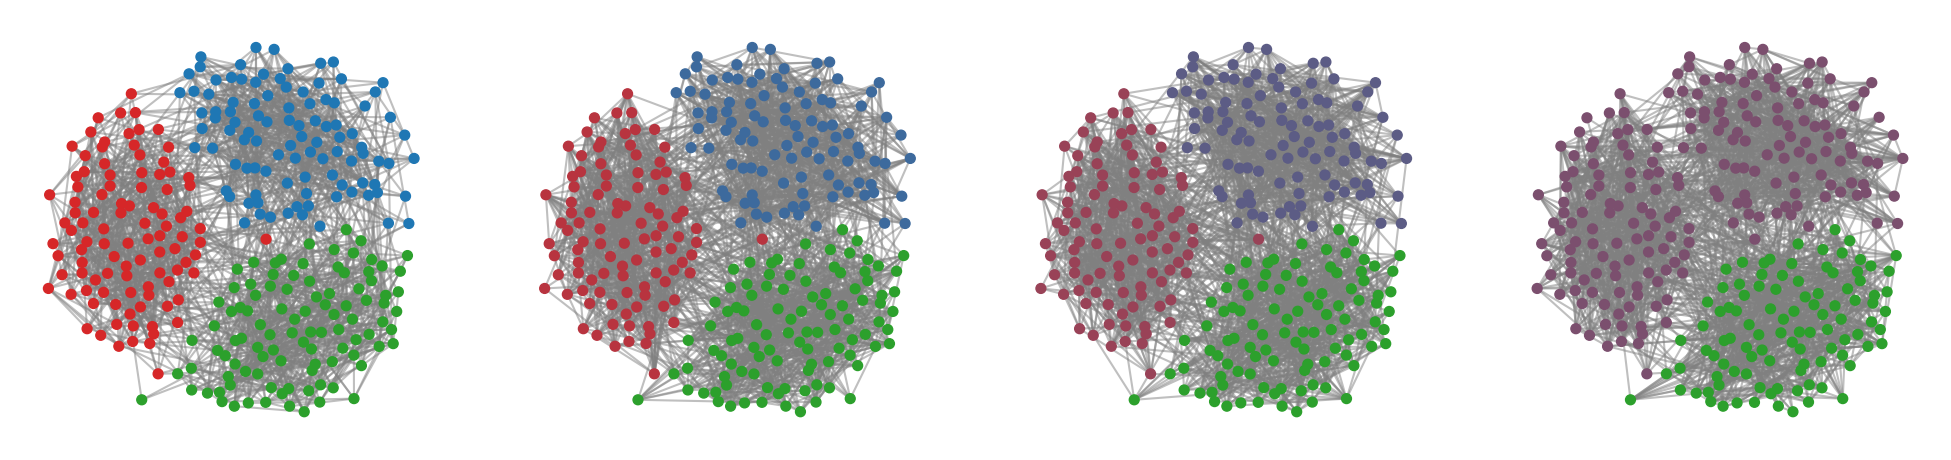

In [66]:
graphs = generate_n_graphs(n_graphs, n_comms, nodes_per_comm, p_in, p_out)

fig, ax = plt.subplots(1, n_graphs, figsize=(n_graphs*5, 5))
for direction in ['top','right','left','bottom']:
    for axis in ax:
        axis.spines[direction].set_visible(False)
fig.tight_layout()

pos = nx.kamada_kawai_layout(graphs[0])

for x_index, G in enumerate(graphs):

    node_colors = [blue_range[x_index]] * nodes_per_comm + [red_range[x_index]] * nodes_per_comm + [green] * nodes_per_comm

    nx.draw_networkx_nodes(G, ax=ax[x_index], pos=pos, node_size=node_size, node_color=node_colors)
    nx.draw_networkx_edges(G, ax=ax[x_index], edge_color='gray', pos=pos, width=local_edge_width, alpha=local_edge_alpha)

utils.save_figure("global_setup", experiment_folder, overwrite=True)

### Global Results

In [71]:
x_range = list(np.round(np.arange(0, 1.1, 0.1), 1))
angles_to_rotate = list(np.round([45*i for i in x_range],1))
angles_between_opinions = [2*a for a in angles_to_rotate[::-1]]
print(angles_to_rotate, angles_between_opinions)

[0.0, 4.5, 9.0, 13.5, 18.0, 22.5, 27.0, 31.5, 36.0, 40.5, 45.0] [90.0, 81.0, 72.0, 63.0, 54.0, 45.0, 36.0, 27.0, 18.0, 9.0, 0.0]


In [91]:
def unshare_yaxis(ax, axis):
    # Unshare y-axis for the 'axis' axis
    grouper = ax[axis].get_shared_y_axes()
    grouper.remove(ax[axis])

    # Create and assign new ticker
    xticker = mpl.axis.Ticker()
    ax[axis].yaxis.major = xticker

    # The new ticker needs new locator and formatters
    ax[axis].yaxis.set_major_locator(mpl.ticker.AutoLocator())
    ax[axis].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

Figure saved


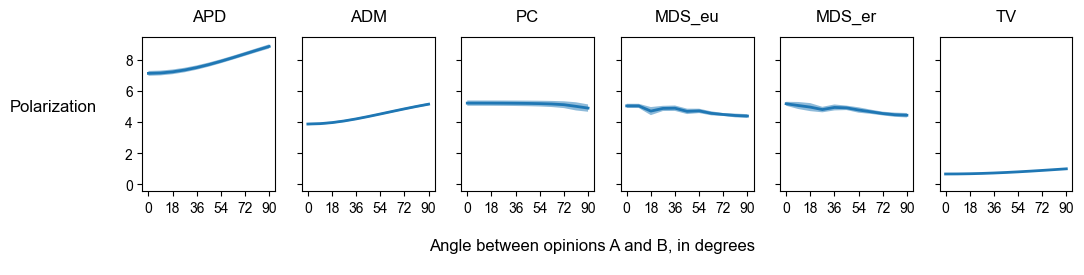

In [97]:
fig, ax = plt.subplots(1, len(metrics), figsize=(len(metrics)*2, 2), sharey=True, sharex=True)

# Set labels and ticks to every 20 degrees
ax[0].set_xticks(angles_between_opinions[::2])
ax[0].set_xticklabels([str(int(a)) for a in angles_between_opinions[::2]]) 

# Set x limits
# ax[0].set_xlim(angles_between_opinions[0]-0.2, angles_between_opinions[-1]+0.2)

for metric_index, (metric_name, polarization_metric) in enumerate(metrics):

    # initialize array for polarization values with shape (SBM_runs,len(x_range))
    run_pols = np.zeros((SBM_runs, len(angles_between_opinions)))
    
    for run in range(SBM_runs):

        G = utils.stochastic_block_model(n_comms, nodes_per_comm, p_in, p_out)

        for i, rotation_angle in enumerate(angles_to_rotate):

            # Rotate opinions towards each other
            rot_o_blue = rotate(o_blue, rotation_angle)
            rot_o_red = rotate(o_red, -rotation_angle)

            # print the angle for debugging
            # if run == 0:
            #     angle = np.degrees(np.arccos(np.clip(np.dot(rot_o_blue, rot_o_red), -1.0, 1.0)))
            #     print(angle)

            o = pd.DataFrame(np.vstack((np.array([tuple(rot_o_blue)]*nodes_per_comm),
                                        np.array([tuple(rot_o_red)]*nodes_per_comm),
                                        np.array([tuple(o_green)]*nodes_per_comm))))
            
            tensor = nvd.make_tensor(G, o)
            polarization = polarization_metric(tensor)
            run_pols[run, i] = polarization

    means = np.mean(run_pols, axis=0)

    # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
    run_pols += np.random.normal(0, 1e-10, run_pols.shape)

    # Calculate the 95% confidence intervals matrix with graphs on columns
    conf = np.array([st.t.interval(0.95, run_pols.shape[1]-1, loc=means[i], scale=st.sem(run_pols[:,i])) for i in range(len(angles_between_opinions))])

    ax[metric_index].fill_between(angles_between_opinions, conf[:,1], conf[:,0], alpha=.5, linewidth=0)  # , label='95% CI'

    # Draw line at 0 for layout purposes
    ax[metric_index].hlines(0, angles_between_opinions[0]-1, xmax=angles_between_opinions[-1]+1, colors='black', alpha=0, linestyles='dashed')

    ax[metric_index].plot(angles_between_opinions, means, lw=2)

    # Add title
    ax[metric_index].set_title(metric_name, fontsize=12, y=1.05, ha='center')

    # Add title to the first column
    if metric_index == 0:
        ax[metric_index].set_ylabel("Polarization", rotation=0, labelpad=20, fontsize=12, ha='right')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='lower right', ncol=1, fontsize=12, bbox_to_anchor=(0.8, -0.3), frameon=False)

fig.supxlabel('Angle between opinions A and B, in degrees', fontsize=12, y=-0.2)

utils.save_figure("global_res", experiment_folder, overwrite=True)